Entrainement de modèles de base et d'un modèle CatModel qui les concatène.  

Les définitions communes sont dans **rakuten_common.py**
  * NB_ECHANTILLONS: Nombre d'échantillons utilisés (-1 par défaut => tous)
  * TEST_SIZE: Ratio utilisé pour les tests (0.2 par défaut)
  * VALIDATION_SPLIT: Ratio utilisé pour la validation (0.15 par défaut)
  * RakutenBaseModel: Classe de base des modèles
  * RakutenCatModel: Classe de base pour les modèles utilisant des modèles de base
  * get_X...: Fonctions diverses retournant des données preprocessées, créant un fichier cache si nécessaire

Les fichiers intermédiaires et finaux sont tous créés dans le répertoire **modele_rakuten_out**.

L'exécution d'un modèle se fait ainsi:

        modele().evaluate(NB_ECHANTILLONS)  

Après entrainement et prédiction, un rapport est affiché et le modèle est sauvegardé sur disque.

Le modèle qui utilise des modèles de base déjà exécutés les déclare dans la méthode **config** (voir objs dans CatModel.config()): Les objets de bases suvegardés sur disque sont alors chargés, pour récupérer l'architecture de leurs layers ainsi que leurs poids, afin de construire le modèle concaténant.


In [1]:
from rakuten_common import *

In [2]:
class EmbedRNN(RakutenBaseModel):
    """
    Modèle texte avec un layer Embedding et un layer GRU
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.maxlen = 600
            self.num_words = 70000
            self.embedding_dim = 200
            self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=self.num_words)

    def get_class_weight(self):
        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
        cw = {i: 1 for i in range(NB_CLASSES)}
        #cw[indices[1280]] = 2
        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.maxlen,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.Embedding(self.num_words, self.embedding_dim,
                                      name=self.layer_name("embed"))(inp)
        x = tf.keras.layers.GRU(128, return_sequences=True,
                                name=self.layer_name("gru"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.GlobalAveragePooling1D(name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dense(256, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.3, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text(input_file)[off_start:off_end]
        self.tokenizer.fit_on_texts(X_train)
        self.word2idx = self.tokenizer.word_index
        self.idx2word = self.tokenizer.index_word
        self.vocab_size = self.tokenizer.num_words
        
        X_train = self.tokenizer.texts_to_sequences(X_train)
        X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                                maxlen=self.maxlen,
                                                                padding='post')
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = self.tokenizer.texts_to_sequences(X_test)
        X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                               maxlen=self.maxlen,
                                                               padding='post')

        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=8, patience_lr=3,
                                          class_weight=[])

++ [08h48mn] EmbedRNN: Evaluation avec 84916 échantillons
++ [08h48mn] EmbedRNN: fit(): Début
Epoch 1/50
2219/2219 [==============================] - 474s 212ms/step - loss: 1.3969 - accuracy: 0.5778 - val_loss: 0.7255 - val_accuracy: 0.7788
Epoch 2/50
2219/2219 [==============================] - 470s 212ms/step - loss: 0.5295 - accuracy: 0.8423 - val_loss: 0.6109 - val_accuracy: 0.8187
Epoch 3/50
2219/2219 [==============================] - 472s 212ms/step - loss: 0.2913 - accuracy: 0.9117 - val_loss: 0.6750 - val_accuracy: 0.8179
Epoch 4/50
2219/2219 [==============================] - 472s 213ms/step - loss: 0.1688 - accuracy: 0.9480 - val_loss: 0.7711 - val_accuracy: 0.8173
Epoch 5/50
2219/2219 [==============================] - 473s 213ms/step - loss: 0.1055 - accuracy: 0.9672 - val_loss: 0.9386 - val_accuracy: 0.8140

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/50
2219/2219 [==============================] - 472s 213ms/step - loss: 0.04

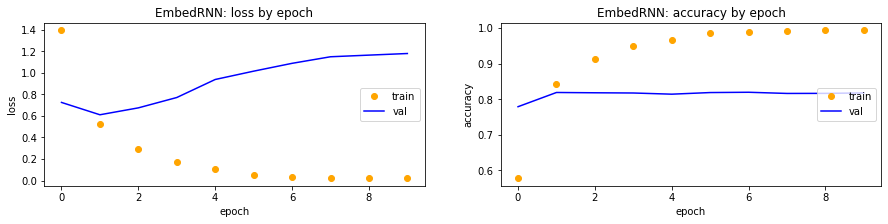

++ [10h07mn] EmbedRNN: fit(): Fin

++ [10h07mn] EmbedRNN: predict(): Début
133/133 [==============================] - 3s 18ms/step
++ [10h07mn] EmbedRNN: predict(): Fin

++ [10h07mn] EmbedRNN: w-f1-score = 0.8213

              precision    recall  f1-score   support

          10       0.49      0.66      0.56       146
        1140       0.80      0.75      0.77       138
        1160       0.90      0.95      0.92       189
        1180       0.54      0.54      0.54        37
        1280       0.64      0.77      0.70       222
        1281       0.65      0.49      0.56       115
        1300       0.98      0.92      0.95       261
        1301       0.93      0.97      0.95        38
        1302       0.87      0.72      0.79       120
        1320       0.78      0.75      0.76       157
        1560       0.77      0.84      0.80       232
        1920       0.92      0.86      0.89       209
        1940       0.78      0.90      0.84        40
        2060       0.80      

In [8]:
EmbedRNN().evaluate(NB_ECHANTILLONS)

In [3]:
class Multilingu(RakutenBaseModel):
    """
    Utilisation d'un modèle texte pré-entrainé (Multilingual-large) pour obtenir
    des vecteurs d'embedding.
    La fonction get_X_text_embed_multilingual() retourne ces vecteurs. Les plongements
    des phrases sont effectués lors de la première exécution et stocké dans un fichier
    qui est simplement lu par la suite.
    Pour utiliser ce mdèle il faut télécharger 
           https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3
    et l'extraire en tant que tfhub/universal-sentence-encoder-multilingual-large-3
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "std"):
            # Appel pour la création du modèle
            self.embedding_length = 512 # Défini par le modèle Multilingual/large
            self.std = StandardScaler()

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=(self.embedding_length,),
                                    name=self.layer_name("input"))
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(inp)
        x = tf.keras.layers.Dense(200, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
#        x = tf.keras.layers.Dense(100, activation='relu', name=self.layer_name("dense"))(x)
#        x = tf.keras.layers.Dropout(0.4, name=self.layer_name("dropout"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_train = self.std.fit_transform(X_train)
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        X_test = get_X_text_embed_multilingual(input_file)[off_start:off_end]
        X_test = self.std.transform(X_test)
        return X_test

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val, optimizer='adam',
                                         epochs=50, patience_stop=7, patience_lr=3)


++ [08h45mn] Multilingu: Evaluation avec 84916 échantillons
++ [08h45mn] Multilingu: fit(): Début
Epoch 1/50
2219/2219 [==============================] - 10s 4ms/step - loss: 1.0390 - accuracy: 0.6910 - val_loss: 0.7175 - val_accuracy: 0.7712
Epoch 2/50
2219/2219 [==============================] - 8s 4ms/step - loss: 0.7946 - accuracy: 0.7527 - val_loss: 0.6681 - val_accuracy: 0.7896
Epoch 3/50
2219/2219 [==============================] - 8s 4ms/step - loss: 0.7365 - accuracy: 0.7667 - val_loss: 0.6543 - val_accuracy: 0.7945
Epoch 4/50
2219/2219 [==============================] - 8s 4ms/step - loss: 0.6964 - accuracy: 0.7788 - val_loss: 0.6407 - val_accuracy: 0.7961
Epoch 5/50
2219/2219 [==============================] - 8s 4ms/step - loss: 0.6643 - accuracy: 0.7861 - val_loss: 0.6454 - val_accuracy: 0.7968
Epoch 6/50
2219/2219 [==============================] - 8s 4ms/step - loss: 0.6396 - accuracy: 0.7929 - val_loss: 0.6367 - val_accuracy: 0.8027
Epoch 7/50
2219/2219 [===============

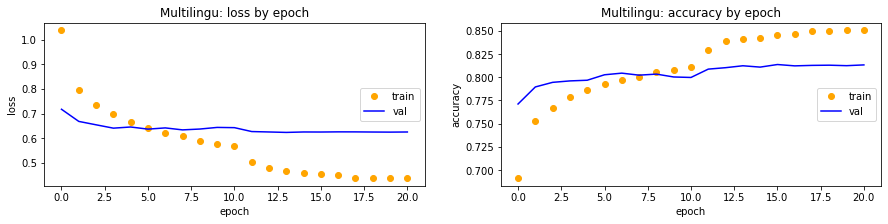

++ [08h48mn] Multilingu: fit(): Fin

++ [08h48mn] Multilingu: predict(): Début
133/133 [==============================] - 0s 923us/step
++ [08h48mn] Multilingu: predict(): Fin

++ [08h48mn] Multilingu: w-f1-score = 0.8115

              precision    recall  f1-score   support

          10       0.56      0.61      0.58       146
        1140       0.69      0.74      0.71       138
        1160       0.91      0.92      0.92       189
        1180       0.64      0.57      0.60        37
        1280       0.60      0.61      0.60       222
        1281       0.72      0.50      0.59       115
        1300       0.83      0.93      0.88       261
        1301       0.89      0.87      0.88        38
        1302       0.78      0.69      0.73       120
        1320       0.75      0.78      0.76       157
        1560       0.74      0.78      0.76       232
        1920       0.88      0.89      0.89       209
        1940       0.90      0.95      0.93        40
        2060       0

In [6]:
Multilingu().evaluate(NB_ECHANTILLONS)

In [4]:
class NPDataset(tf.keras.utils.Sequence):
    """
    Générateur qui extrait les données (de type tableau numpy)
    à partir d'un path de fichier (passer par un fichier évite
    le risque de OOM avec les grosses matrices denses one hot)
    """
    def __init__(self, batch_size,
                 X, y=None, shuffle=False, random_state=1968):
        nb = len(X)
        self.y = y
        self.batch_size = batch_size
        self.batch_number = int(nb / batch_size)
        self.batch_indexes = range(self.batch_number)
        self.prefix = re.match(r'^(.*)_\d+\.npy$', X[0]).group(1)
        if shuffle:
            self.random_state = random_state
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=random_state)
        self.shuffle = shuffle

    def __len__(self):
        """ Retourne le nombre de batchs """
        return self.batch_number

    def __getitem__(self, index):
        index = self.batch_indexes[index]
        X = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            f = f"{self.prefix}_{i}.npy"
            with open(f, 'rb') as fd:
                x = np.load(fd)
                X.append(x)
        X = np.array(X)
        if self.y is None:
            return X
        else:
            y = self.y[index*self.batch_size : (index+1)*self.batch_size]
            return X, y

    def on_epoch_end(self):
        """ Changements effectués à chaque fin d'époque """
        if self.shuffle:
            self.batch_indexes = sklearn.utils.shuffle(self.batch_indexes,
                                                       random_state=self.random_state)
        

class TextOneHot(RakutenBaseModel):
    """
    Mini modèle NN exécuté après un préprocessing des données effectué
    avec un pipe sklearn TfidfVectorizer | SelectFromModel(LinearSVC)
    
    Il faut télécharger la base de donnée Spacy pour le français:
                     python -m spacy download fr_core_news_sm
    Les textes sont tokenizés et lemattisés en utilisant Spacy, la fonction
    get_X_text_spacy_lemma() retourne ces textes préprocessés en les lisant
    dans un fichier qui est construit lors de la première utilisation.
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        if not hasattr(self, "select"):
            # Appel pour la création du modèle
            self.privatedir = os.path.join(OUTDIR, self.name)
            self.maxfeatures = 50000 # Nombre de features selectionnées par SVC
            self.select = make_pipeline(
                TfidfVectorizer(analyzer='word',
                  #strip_accents='ascii',
                  #stop_words=french_stop_words, 
                  #    tokenizer=tokenize_spacy, # les données sont déjà tokenizées
                  preprocessor=' '.join,
                  lowercase=False,
                  stop_words=None,
                  max_df=0.8,
                  min_df=2,
                  ngram_range=(1,2),
                  use_idf=True,
                  smooth_idf=True,
                  sublinear_tf=False,
                  binary=True,
 #                 max_features=30000,  moins rentable que celui de SelectFromModel 
                  ),
                  SelectFromModel(LinearSVC(penalty="l2", dual=True, C=0.8,
                                            tol=1e-5, max_iter=4000),
                                  max_features=self.maxfeatures))

    def __flush_data_to_file(self, data, tag, off_start, off_end, input_file=None):
        if not os.path.isdir(self.privatedir):
            os.makedirs(self.privatedir)
        filelist = []
        for i in range(data.shape[0]):
            f = os.path.join(self.privatedir,
                             f"{tag}_{off_start}_{off_end}_{i}.npy")
            with open(f, 'wb') as fd:
                datum = data[i].toarray()[0]
                np.save(fd, datum)
            filelist.append(f)
        return filelist
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une donnée preprocessée à partir d'un fichier
        et la retourner
        """
        with open(filepath, 'rb') as fd:
            datum = np.load(fd)
        return datum

#    def get_class_weight(self):
#        indices = {int(self.fit_labels[i]):i for i in self.fit_labels}
#        cw = {i: 1 for i in range(NB_CLASSES)}
#        cw[indices[10]] = 2
#        return cw

    def get_model_body(self):
        self.layer_index = 0
        inp = tf.keras.layers.Input(shape=self.input_shape, name=self.layer_name("input"))
        x = inp
        x = tf.keras.layers.Dense(90, activation='relu', name=self.layer_name("dense"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.BatchNormalization(name=self.layer_name("batchnorm"))(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        y_train = get_y()[off_start:off_end]
#            X_train = get_X_text(input_file)[off_start:off_end]
        X_train = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_train = self.select.fit_transform(X_train, y_train)
        self.input_shape = X_train.shape[1:]
        self.prt(f"Nombre de mots retenus = {self.input_shape[0]}")
        return self.__flush_data_to_file(X_train, "train", off_start, off_end)

    def preprocess_X_test(self, off_start, off_end, input_file=None):
#        X_test = get_X_text(input_file)[off_start:off_end]
        X_test = get_X_text_spacy_lemma(input_file)[off_start:off_end]
        X_test = self.select.transform(X_test)
        return self.__flush_data_to_file(X_test, "test", off_start, off_end)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)
        trainds = NPDataset(self.batch_size, X_train, y_train, shuffle=True)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)
        valds = NPDataset(self.batch_size, X_val, y_val, shuffle=True)

        self.model = self.get_model()

        return self.compile_and_train_dataset(trainds, valds,
                                              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                              epochs=20,
                                              patience_stop=6, patience_lr=3)

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testds = NPDataset(1, X_test, shuffle=False)
        return self.model_predict(testds)

++ [10h07mn] TextOneHot: Evaluation avec 84916 échantillons
++ [10h08mn] TextOneHot: Nombre de mots retenus = 50000
++ [10h27mn] TextOneHot: fit(): Début
Epoch 1/20
2218/2218 [==============================] - 2376s 1s/step - loss: 1.5080 - accuracy: 0.6595 - val_loss: 0.7261 - val_accuracy: 0.8188
Epoch 2/20
2218/2218 [==============================] - 2202s 993ms/step - loss: 0.6171 - accuracy: 0.8521 - val_loss: 0.5395 - val_accuracy: 0.8444
Epoch 3/20
2218/2218 [==============================] - 2115s 953ms/step - loss: 0.3536 - accuracy: 0.9160 - val_loss: 0.5032 - val_accuracy: 0.8494
Epoch 4/20
2218/2218 [==============================] - 2185s 985ms/step - loss: 0.2194 - accuracy: 0.9482 - val_loss: 0.5075 - val_accuracy: 0.8514
Epoch 5/20
2218/2218 [==============================] - 2151s 970ms/step - loss: 0.1486 - accuracy: 0.9645 - val_loss: 0.5286 - val_accuracy: 0.8510
Epoch 6/20
2218/2218 [==============================] - 2175s 981ms/step - loss: 0.1051 - accuracy: 0.97

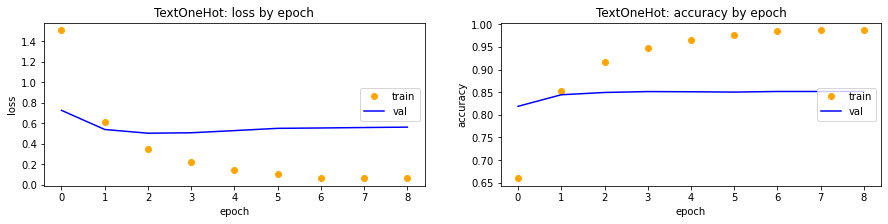

++ [15h54mn] TextOneHot: fit(): Fin

++ [15h56mn] TextOneHot: predict(): Début
4246/4246 [==============================] - 55s 13ms/step
++ [15h57mn] TextOneHot: predict(): Fin

++ [15h57mn] TextOneHot: w-f1-score = 0.8523

              precision    recall  f1-score   support

          10       0.52      0.61      0.56       146
        1140       0.79      0.79      0.79       138
        1160       0.95      0.95      0.95       189
        1180       0.93      0.73      0.82        37
        1280       0.70      0.76      0.73       222
        1281       0.74      0.60      0.66       115
        1300       0.96      0.95      0.96       261
        1301       0.97      0.95      0.96        38
        1302       0.90      0.84      0.87       120
        1320       0.88      0.84      0.86       157
        1560       0.83      0.84      0.84       232
        1920       0.91      0.93      0.92       209
        1940       0.91      1.00      0.95        40
        2060      

In [10]:
TextOneHot().evaluate(NB_ECHANTILLONS)

In [5]:
import transformers

class CamemBert(RakutenBaseModel):
    """
    Modèle BERT pour langue française
    Télécharger les fichiers qui suivent à partir de
              https://huggingface.co/jplu/tf-camembert-base/tree/main/
    et les copier dans le sous répertoire local
              huggingface/tf-camembert-base/
     * config.json
     * sentencepiece.bpe.model
     * tf_model.h5
    """
    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.max_length = 400 # epochs pour 200 sur CPU = 5h
        self.bertdir = os.path.join("huggingface", "tf-camembert-base")
        self.tokenizer = transformers.CamembertTokenizer.from_pretrained(self.bertdir,
                                                            local_files_only=True)

    def get_model_body(self):
        self.layer_index = 0
        bert_model = transformers.TFCamembertModel.from_pretrained(self.bertdir,
                                                               local_files_only=True)
        txt_input = tf.keras.layers.Input(shape=(self.max_length,), dtype="int32")
        att_input = tf.keras.layers.Input(shape=(self.max_length,), dtype="int32")
        inp = [txt_input, att_input]
        x = bert_model(txt_input,attention_mask=att_input)[1]
#    x = tf.keras.layers.Dense(200, activation="relu")(x)
#    x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(100, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        return inp, x

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        X_train = get_X_text(input_file)[off_start:off_end]
        seqs = self.tokenizer.batch_encode_plus(X_train,
                                                max_length=self.max_length,
                                                padding="max_length",
                                                truncation=True)
        return np.asarray(seqs["input_ids"]),\
               np.asarray(seqs["attention_mask"]),
        return X_train

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return self.preprocess_X_train(off_start, off_end, input_file)

    def fit(self, off_start, off_val, off_end, input_file=None):

        X_train = self.preprocess_X_train(off_start, off_val, input_file)
        y_train = self.preprocess_y_train(off_start, off_val, input_file)

        X_val = self.preprocess_X_test(off_val, off_end, input_file)
        y_val = self.preprocess_y_train(off_val, off_end, input_file)

        self.model = self.get_model()

        self.prt("Congélation des couches suivantes:")
        for layer in self.model.layers:
            if layer.name.find("tf_camembert") >= 0:
                print(f"   - {layer.name}")
                layer.trainable = False
        
        self.compile_and_train_gen(X_train, y_train, X_val, y_val,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                                    epochs=2, patience_stop=2, patience_lr=1)
        self.prt("Déongélation des couches suivantes:")
        for layer in self.model.layers:
            if not layer.trainable:
                print(f"   - {layer.name}")
                layer.trainable = True
        
        return self.compile_and_train_gen(X_train, y_train, X_val, y_val,
                                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
                                          epochs=5, patience_stop=2, patience_lr=1)

In [ ]:
CamemBert().evaluate(NB_ECHANTILLONS)

In [5]:
class EffNetB1(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec EfficientNet et l'utilisation
    d'un générateur d'images augmentées.
    https://www.dlology.com/blog/transfer-learning-with-efficientnet/
    Le modèle B5 a le format d'image (456x456) le plus proche de celles à
    classer (500x500), il est plus performant que B1 (~0.87 versus ~0.85)
    mais beaucoup plus coûteux en temps d'éxecution.
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = None # Inclus dans le modèle
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 20
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.EfficientNetB1(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008),
                                    patience_lr=3,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)


++ [19h58mn] EffNetB1: Evaluation avec 84916 échantillons
++ [19h58mn] EffNetB1: Création des générateurs d'images
Found 70990 validated image filenames belonging to 27 classes.
Found 9680 validated image filenames belonging to 27 classes.
++ [19h58mn] EffNetB1: Congélation des layers du modèle de base et entrainement
++ [19h58mn] EffNetB1: fit(): Début
Epoch 1/10
2219/2219 [==============================] - 1317s 589ms/step - loss: 1.8122 - accuracy: 0.4766 - val_loss: 1.5497 - val_accuracy: 0.5327
Epoch 2/10
2219/2219 [==============================] - 1306s 588ms/step - loss: 1.5979 - accuracy: 0.5262 - val_loss: 1.4545 - val_accuracy: 0.5620
Epoch 3/10
2219/2219 [==============================] - 1305s 588ms/step - loss: 1.5395 - accuracy: 0.5419 - val_loss: 1.4662 - val_accuracy: 0.5739
Epoch 4/10
2219/2219 [==============================] - 1305s 588ms/step - loss: 1.4959 - accuracy: 0.5539 - val_loss: 1.3907 - val_accuracy: 0.5812
Epoch 5/10
2219/2219 [==========================

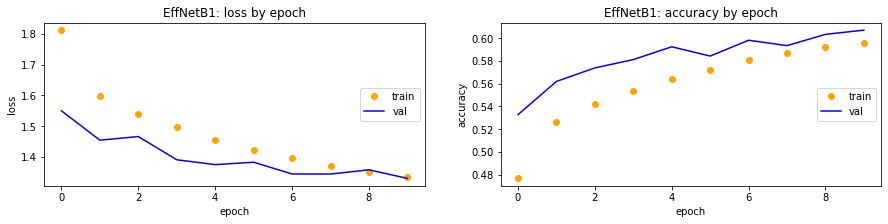

++ [23h39mn] EffNetB1: fit(): Fin

++ [23h39mn] EffNetB1: Décongélation des 8 derniers layers et entrainement
++ [23h39mn] EffNetB1: fit(): Début
Epoch 1/20
2219/2219 [==============================] - 1316s 589ms/step - loss: 1.2232 - accuracy: 0.6258 - val_loss: 1.2288 - val_accuracy: 0.6274
Epoch 2/20
2219/2219 [==============================] - 1312s 591ms/step - loss: 1.1682 - accuracy: 0.6406 - val_loss: 1.2069 - val_accuracy: 0.6329
Epoch 3/20
2219/2219 [==============================] - 1328s 598ms/step - loss: 1.1258 - accuracy: 0.6524 - val_loss: 1.1895 - val_accuracy: 0.6427
Epoch 4/20
2219/2219 [==============================] - 1330s 599ms/step - loss: 1.0955 - accuracy: 0.6639 - val_loss: 1.1812 - val_accuracy: 0.6426
Epoch 5/20
2219/2219 [==============================] - 1322s 596ms/step - loss: 1.0655 - accuracy: 0.6704 - val_loss: 1.1879 - val_accuracy: 0.6445
Epoch 6/20
2219/2219 [==============================] - 1317s 593ms/step - loss: 1.0371 - accuracy: 0.6781 - 

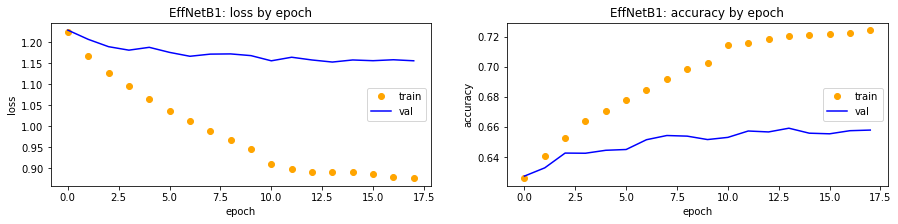

++ [06h16mn] EffNetB1: fit(): Fin

++ [06h16mn] EffNetB1: Entrainement terminé
Found 4246 validated image filenames.
++ [06h16mn] EffNetB1: predict(): Début
4246/4246 [==============================] - 128s 30ms/step
++ [06h18mn] EffNetB1: predict(): Fin

++ [06h18mn] EffNetB1: w-f1-score = 0.6614

              precision    recall  f1-score   support

          10       0.49      0.62      0.55       146
        1140       0.63      0.70      0.66       138
        1160       0.90      0.94      0.92       189
        1180       0.58      0.30      0.39        37
        1280       0.48      0.47      0.47       222
        1281       0.53      0.27      0.36       115
        1300       0.73      0.81      0.77       261
        1301       0.74      0.68      0.71        38
        1302       0.53      0.45      0.49       120
        1320       0.52      0.46      0.49       157
        1560       0.58      0.59      0.58       232
        1920       0.82      0.85      0.83       2

C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


++ [06h18mn] EffNetB1: Modèle sauvegardé dans modele_rakuten_out\EffNetB1_84916_model.hdf5
Pas de sauvegarde de  basemodel
++ [06h18mn] EffNetB1: Objet complet sauvegardé dans modele_rakuten_out\EffNetB1_84916_object.pkl


In [14]:
EffNetB1().evaluate(NB_ECHANTILLONS)

In [12]:
class ResNet50V2(RakutenBaseModel):
    """
    Modèle de transfert learning d'images avec ResNet50V2
    """

    def __init__(self, nb=None):
        super().__init__(self.__class__.__name__, nb)
        self.input_shape = (240, 240, 3) # Dépend du numéro x (EfficientNetBx)
        self.preprocessing_function = tf.keras.applications.resnet_v2.preprocess_input
        self.basetrainable = 8
        self.epochs_freezed = 10
        self.epochs_unfreezed = 20
        self.batch_size = 32

    def preprocess_X_train(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]

    def preprocess_X_test(self, off_start, off_end, input_file=None):
        return get_X_image_path(input_file)[off_start:off_end]
    
    def data_from_file(self, filepath):
        """
        Méthode pour lire une image à partir d'un fichier et la retourner
        au bon format (adapté aux entrées du modèle modèle)
        """
        img = cv2.imread(filepath)
        img = cv2.resize(img, (240, 240), interpolation=cv2.INTER_CUBIC)
        return img

    def get_model_body(self):
        self.layer_index = 0
        self.basemodel = tf.keras.applications.resnet_v2.ResNet50V2(
                                input_shape = self.input_shape,
                                include_top = False,
                                # drop_connect_rate=0.4,
                                weights = 'imagenet')
        inp = Input(shape=self.input_shape, name="input_" + self.name)
        x = self.basemodel(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True,axis=1, name=self.layer_name("batchnorm"))(x)
        x = tf.keras.layers.Dropout(0.5, name=self.layer_name("dropout"))(x)
        x = tf.keras.layers.Dense(512, activation="relu", name=self.layer_name("dense"))(x)
        x = tf.keras.layers.BatchNormalization(trainable = True, axis=1, name=self.layer_name("batchnorm"))(x)
        return inp, x

    def __get_train_dataset(self, X_imagepaths, y_train):
        df = pd.DataFrame({"imgpath": X_imagepaths, "class": y_train})
        datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                                    validation_split = VALIDATION_SPLIT,
                                    preprocessing_function = self.preprocessing_function,
                                    rotation_range = 10,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    brightness_range=[0.9, 1.1],
                                    horizontal_flip = True
                                    )
        traingen = datagenerator.flow_from_dataframe(subset = 'training', dataframe=df,
                                                     x_col="imgpath", y_col="class",
                                                     class_mode="sparse",
                                                     target_size=(self.input_shape[0], self.input_shape[1]),
                                                     batch_size=self.batch_size)
        valgen = datagenerator.flow_from_dataframe(subset='validation',
                                                   dataframe=df, x_col="imgpath", y_col="class",
                                                   class_mode="sparse",
                                                   target_size=(self.input_shape[0], self.input_shape[1]),
                                                   batch_size=self.batch_size)
        return traingen, valgen

    def __get_test_dataset(self, X_imagepaths):
        df = pd.DataFrame({"imgpath": X_imagepaths,
                           "class": [0 for _ in range(len(X_imagepaths))]})
        testgen = tf.keras.preprocessing.image.ImageDataGenerator( 
                        preprocessing_function = self.preprocessing_function).flow_from_dataframe(
                        dataframe=df, x_col="imgpath", y_col="class",
                        class_mode=None, target_size=(self.input_shape[0], self.input_shape[1]),
                        batch_size=1,
                        shuffle = False)
        return testgen

    def fit(self, off_start, off_val, off_end, input_file=None):

        self.prt(f"Création des générateurs d'images")
        X_imgpaths = get_X_image_path(input_file)[off_start:off_end]
        y_train = get_y()[off_start:off_end]
        traingen, valgen = self.__get_train_dataset(X_imgpaths, y_train)
        self.fit_labels = dict((v,k) for k,v in (traingen.class_indices).items())

        self.model = self.get_model()
        
        self.prt(f"Congélation des layers du modèle de base et entrainement")
        for layer in self.basemodel.layers:
            layer.trainable = False
        history = self.compile_and_train_dataset(traingen, valgen,
                                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                         epochs=self.epochs_freezed)
        if self.basetrainable > 0:
            self.prt(f"Décongélation des {self.basetrainable} derniers layers et entrainement")
            for layer in self.basemodel.layers[-self.basetrainable:]:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True
            self.compile_and_train_dataset(traingen, valgen,
                                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.00008),
                                    patience_lr=3,
                                   epochs=self.epochs_unfreezed)
        self.prt("Entrainement terminé")
        return history

    def predict(self, off_start, off_end, input_file=None):
        X_test = self.preprocess_X_test(off_start, off_end, input_file)
        testgen = self.__get_test_dataset(X_test)
        return self.model_predict(testgen)


In [ ]:
ResNet50V2().evaluate(NB_ECHANTILLONS)

In [6]:
class CatModel(RakutenCatModel):
    """
    Modèle qui concatene plusieurs modèles de base. ceux ci sont
    listés et instanciées dans self.objs. le paramètre nb permet
    de corréler les fichiers créés par les modèles de base et le
    modèle de concaténation, ils ont tous le même nb (en pratique
    il s'agit du nombre d'échantillons utilisés).
    
    Le modèle utilise un layer Keras concatenate après appel des
    méthodes get_model_body() de chaque modèle de base afin de
    récupérer l'architecture des layers de ces modèles.

         +----------+  +----------+  +----------+
         | modèle A |  | modèle B |  | modèle C | .....
         +-----+----+  +-----+----+  +-----+----+
               |             |             |
               +-------+     |      +------+
                       |     |      |
                   +---+-----+------+----+
                   |     concatenate     |
                   +---------+-----------+
                             |
                   +---------+----------+
                   | BatchNormalization |
                   +---------+----------+
                             |
                   +---------+----------+
                   | Dense(27, softmax) |
                   +--------------------+
                    
    Une fois le modèle compilé, les poids des layers de bases sont
    initialisés avec ceux des objets modèles de base, grace à la
    méthode copy_submodules_weights().
    """
    def config(self, nb):
        """ Déclaration des modèles de base utilisés """
        if not hasattr(self, "objs") and nb is not None:
            self.objs = [                 # Scores F1 individuels
                         EmbedRNN(nb),    # 0.81
                         TextOneHot(nb),  # 0.85
                         Multilingu(nb),  # 0.8
                         #CamemBert(nb),  # -                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                         #ResNet50V2(nb), # 0.62
                         #Xception(nb),   # 0.62
                         EffNetB1(nb),    # 0.65
                         #EffNetB5(nb),   # 0.67
                        ]

    def __init__(self, nb=None, nobuild=False):
        super().__init__(self.__class__.__name__, nb, nobuild)

        self.config(nb)
        
    def fit(self, off_start, off_val, off_end, input_file=None):
        """
        Entrainement du modèle sur l'intervalle des données spécifié par
        off_start et off_end (offsets dans les fichiers de data).
        """

        self.prt(f'Chargements des modèles référencés "{self.nb}"')
        self.config(self.nb)

        # Générateurs qui alimenteront fit() avec les données train & val
        traingen, valgen = self.create_train_generators(off_start, off_val, off_end,
                                                        input_file)
        
        self.prt(f"Création du modèle")
        # Récupèration des inputs et des outputs de chaque modèle de base
        # pour construire le modèle concatenate
        inputtensors, outputtensors = [], []
        for obj in self.objs:
            inp, outp = obj.get_model_body()
            inputtensors.append(inp)
            outputtensors.append(outp)
        
        self.layer_index = 0 # Utilisé par self.layer_name()
        x = concatenate(outputtensors, axis=-1, name = self.layer_name("concatenate"))
        x = BatchNormalization(name=self.layer_name("batchnorm"))(x)
        x = Dense(NB_CLASSES, activation='softmax', name=self.layer_name("dense"))(x)
        self.model = Model(inputtensors, x, name=self.name)

        # Affichage de l'architecture du modèle
        print(self.model.summary())

        print(f"  * Layers non entrainables:")
        for layer in self.model.layers:
            if layer.name.find(self.name) < 0:
                layer.trainable = False
                print(f"      - {layer.name}")
        print(f"  * Layers entrainables:")
        for layer in self.model.layers:
            if layer.trainable:
                print(f"      - {layer.name}")

        self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])

        # Initialisation des poids
        self.copy_submodels_weights()

        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,
                                             restore_best_weights=True, verbose=1),
                     tf.keras.callbacks.ModelCheckpoint(filepath=self.fbestweights,
                                             save_weights_only=True, save_best_only=True,
                                              monitor='val_loss', mode='min'),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1,
                                                          verbose=1)]
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=5,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)

        print(f"Décongélation des layers suivants:")
        for layer in self.model.layers:
            if not layer.trainable and layer.name.find("efficient") < 0:
                print(f"      - {layer.name}")
        self.model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='sparse_categorical_crossentropy',
                           metrics = ['accuracy'])
        if os.path.isfile(self.fbestweights):
            os.remove(self.fbestweights)
        history = self.model.fit(traingen,
                                 epochs=20,
                                 validation_data = valgen,
                                 callbacks=callbacks)
        if os.path.isfile(self.fbestweights):
            self.model.load_weights(self.fbestweights)
        plot_history(f"{self.name}", history)

        return history

++ [06h18mn] CatModel: Evaluation avec 84916 échantillons
++ [06h18mn] CatModel: Chargements des modèles référencés "84916"
Chargement de l'objet (modele_rakuten_out\EmbedRNN_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EmbedRNN_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\TextOneHot_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNetB1_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNetB1_84916_model.hdf5)
++ [06h18mn] CatModel: Preprocessing des données d'entrainement et validation
++ [06h19mn] TextOneHot: Nombre de mots retenus = 50000
++ [06h37mn] CatModel: Instantiation du générateur d'entrainement
Mélange des données
Nettoyage de modele_rakuten_out\CatDataset_train_70989
Création de 2218 fichiers dans modele_rakuten

  0%|          | 0/2218 [00:00<?, ?it/s]

* modèle TextOneHot


  0%|          | 5/2218 [00:00<00:53, 41.31it/s]

* modèle Multilingu


  0%|          | 0/2218 [00:00<?, ?it/s]

* modèle EffNetB1


 22%|██▏       | 67/302 [00:00<00:00, 667.59it/s]

++ [08h36mn] CatModel: Instantiation du générateur de validation
Mélange des données
Nettoyage de modele_rakuten_out\CatDataset_val_9681
Création de 302 fichiers dans modele_rakuten_out\CatDataset_val_9681
* modèle EmbedRNN


  0%|          | 0/302 [00:00<?, ?it/s]

* modèle TextOneHot


  8%|▊         | 25/302 [00:00<00:01, 249.65it/s]

* modèle Multilingu


  0%|          | 0/302 [00:00<?, ?it/s]

* modèle EffNetB1


100%|██████████| 302/302 [03:37<00:00,  1.39it/s]


++ [08h50mn] CatModel: Création du modèle
Model: "CatModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_EffNetB1 (InputLayer)     [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
input_1_EmbedRNN (InputLayer)   [(None, 600)]        0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 8, 8, 1280)   6575239     input_EffNetB1[0][0]             
__________________________________________________________________________________________________
embed_2_EmbedRNN (Embedding)    (None, 600, 200)     14000000    input_1_EmbedRNN[0][0]           
_________________________________________________

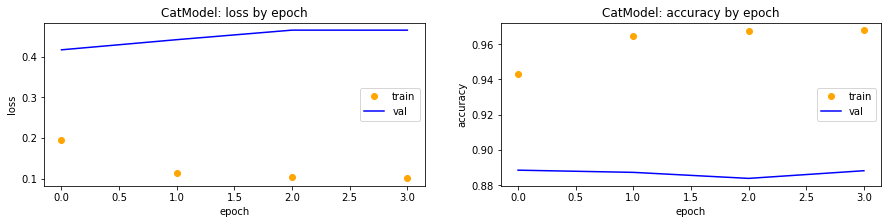

Décongélation des layers suivants:
      - input_EffNetB1
      - input_1_EmbedRNN
      - embed_2_EmbedRNN
      - global_average_pooling2d_2
      - gru_3_EmbedRNN
      - dense_1_EffNetB1
      - dropout_4_EmbedRNN
      - input_1_TextOneHot
      - input_1_Multilingu
      - batchnorm_2_EffNetB1
      - batchnorm_5_EmbedRNN
      - dense_2_TextOneHot
      - batchnorm_2_Multilingu
      - dropout_3_EffNetB1
      - dense_6_EmbedRNN
      - dropout_3_TextOneHot
      - dense_3_Multilingu
      - dense_4_EffNetB1
      - dropout_7_EmbedRNN
      - batchnorm_4_TextOneHot
      - dropout_4_Multilingu
      - batchnorm_5_EffNetB1
Epoch 1/20
2218/2218 [==============================] - 722s 321ms/step - loss: 0.1044 - accuracy: 0.9671 - val_loss: 0.4067 - val_accuracy: 0.8893
Epoch 2/20
2218/2218 [==============================] - 705s 318ms/step - loss: 0.0999 - accuracy: 0.9686 - val_loss: 0.4063 - val_accuracy: 0.8903
Epoch 3/20
2218/2218 [==============================] - 705s 318ms/

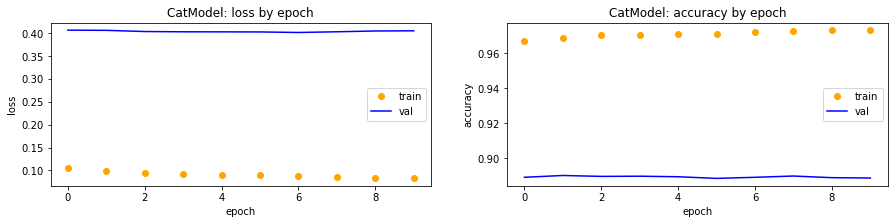

++ [11h37mn] CatModel: Prédiction pour 4246 échantillons
++ [11h37mn] CatModel: Preprocessing des 4246 données de test


  0%|          | 0/4246 [00:00<?, ?it/s]

++ [11h38mn] CatModel: Instantiation du générateur de test
Mélange des données
Nettoyage de modele_rakuten_out\CatDataset_test_4246
Création de 4246 fichiers dans modele_rakuten_out\CatDataset_test_4246
* modèle EmbedRNN


  0%|          | 0/4246 [00:00<?, ?it/s]

* modèle TextOneHot


  0%|          | 13/4246 [00:00<00:37, 112.17it/s]

* modèle Multilingu


  0%|          | 3/4246 [00:00<02:53, 24.40it/s]

* modèle EffNetB1


100%|██████████| 4246/4246 [05:03<00:00, 14.01it/s]


++ [11h46mn] CatModel: predict(): Début
4246/4246 [==============================] - 157s 36ms/step
++ [11h48mn] CatModel: predict(): Fin

++ [11h48mn] CatModel: w-f1-score = 0.8854

              precision    recall  f1-score   support

          10       0.68      0.73      0.70       146
        1140       0.85      0.84      0.85       138
        1160       0.97      0.99      0.98       189
        1180       0.81      0.70      0.75        37
        1280       0.75      0.80      0.77       222
        1281       0.71      0.67      0.69       115
        1300       0.97      0.96      0.96       261
        1301       0.97      0.97      0.97        38
        1302       0.88      0.82      0.85       120
        1320       0.86      0.86      0.86       157
        1560       0.84      0.88      0.86       232
        1920       0.91      0.92      0.92       209
        1940       0.95      0.95      0.95        40
        2060       0.84      0.85      0.85       275
      

C:\Users\Eric\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


++ [11h48mn] CatModel: Modèle sauvegardé dans modele_rakuten_out\CatModel_84916_model.hdf5
Pas de sauvegarde de  objs
++ [11h48mn] CatModel: Objet complet sauvegardé dans modele_rakuten_out\CatModel_84916_object.pkl


In [16]:
CatModel().evaluate(NB_ECHANTILLONS)

Chargement de l'objet (modele_rakuten_out\CatModel_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\CatModel_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EmbedRNN_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EmbedRNN_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\TextOneHot_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNetB1_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNetB1_84916_model.hdf5)


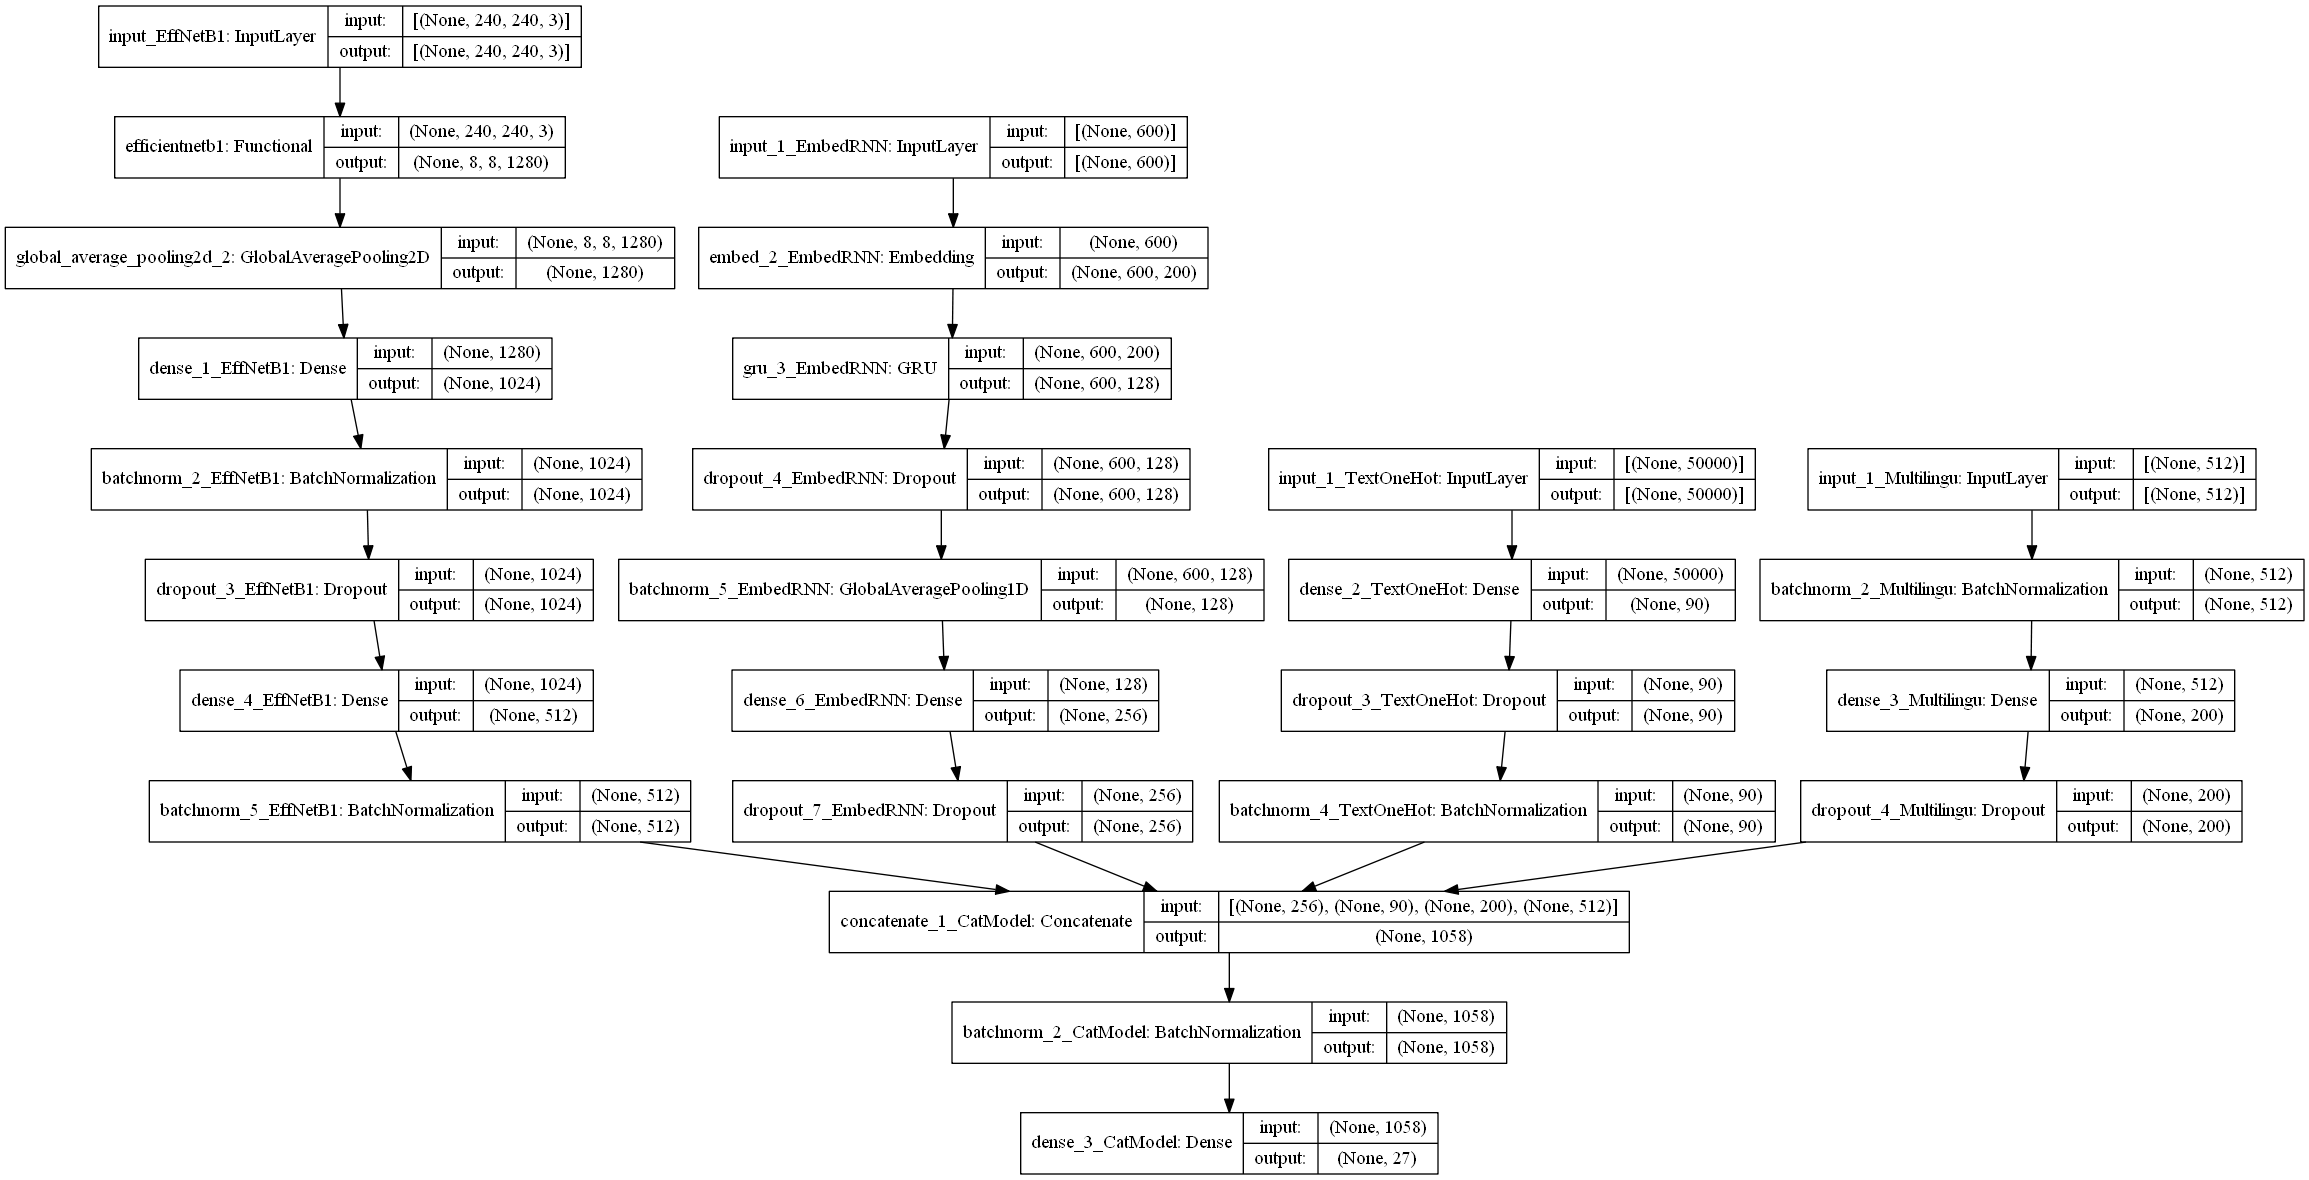

In [17]:
tf.keras.utils.plot_model(CatModel(NB_ECHANTILLONS).model,
                          show_shapes = True,
                          show_layer_names = True)

Classes les plus mal prédites:


,1280,2060,10,1281,2403,2280,1560,2582,40,1320,1140,1302,2522,2585,1920,2705,1180,1300,2462,50
Erreurs,45,41,40,38,31,30,29,27,23,22,22,21,19,17,17,14,11,11,9,5


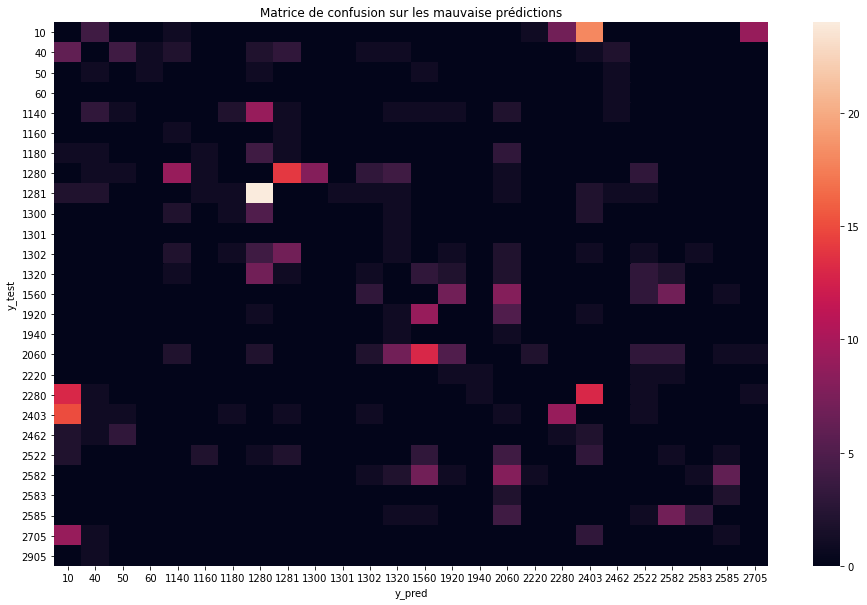

In [18]:
# Analyse des mauvaises prédictions à partir du fichier généré
# ne contenant que les mauvaises prédictions
badf = "modele_rakuten_out\CatModel_84916_bad_predictions.csv"
df = pd.read_csv(badf)

print("Classes les plus mal prédites:")
vc = df.y_test.value_counts()
display(pd.DataFrame(vc[:20]).transpose().rename(index = {'y_test': 'Erreurs'}))

plt.figure(figsize=(16,10))
sns.heatmap(pd.crosstab(df.y_test, df.y_pred))
plt.title("Matrice de confusion sur les mauvaise prédictions")
plt.show()

In [7]:
# Sauvegarde des modèles et création du fichier csv des
# prédictions sur le fichier officiel de test
CatModel(NB_ECHANTILLONS).deliver()

Chargement de l'objet (modele_rakuten_out\CatModel_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\CatModel_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EmbedRNN_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EmbedRNN_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\TextOneHot_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\TextOneHot_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\Multilingu_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\Multilingu_84916_model.hdf5)
Chargement de l'objet (modele_rakuten_out\EffNetB1_84916_object.pkl)
Chargement du modèle (modele_rakuten_out\EffNetB1_84916_model.hdf5)
++ [12h15mn] CatModel: Création de modele_rakuten_out\liv\2021_08_09_12h15\CatModel_graph.png
++ [12h15mn] CatModel: Sauvegarde des modèles dans modele_rakuten_out\liv\2021_08_09_12h15
   modele_rakuten_out\liv\2021_08_09_12h15\CamemBert_84916_model.hdf5
   modele_rakuten_out\liv\2021_08_09_12h15\CatModel_

  0%|          | 23/13812 [00:00<01:02, 220.58it/s]

Création de 13812 fichiers dans modele_rakuten_out\CatDataset_test_13812
* modèle EmbedRNN


  0%|          | 8/13812 [00:00<03:05, 74.31it/s]

* modèle TextOneHot


  0%|          | 2/13812 [00:00<13:56, 16.50it/s]

* modèle Multilingu


  0%|          | 0/13812 [00:00<?, ?it/s]

* modèle EffNetB1


100%|██████████| 13812/13812 [11:59<00:00, 19.19it/s] 


++ [12h42mn] CatModel: predict(): Début
13812/13812 [==============================] - 573s 39ms/step
++ [12h52mn] CatModel: predict(): Fin

++ [12h52mn] CatModel: Création de modele_rakuten_out\liv\2021_08_09_12h15\Y_test.csv
